# Introduction

Hello, I'm **Wesley**, nice to meet you! 👋

Since adding **Joy** and **Sadnesss** with **Anger** in the [Twitter Emotion MultiClass Classifier Notebook](https://www.kaggle.com/code/wesleyacheng/twitter-emotion-classification-with-bert), I wanted to complete the **Inside Out** group with **Fear** and **Disgust**!

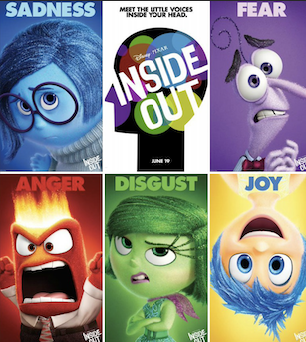

Here we'll be making a **Twitter Emotion MultiLabel Classifier** by doing transfer learning on [BERT](https://arxiv.org/pdf/1810.04805.pdf) with the [SemEval Twitter Dataset](https://huggingface.co/datasets/sem_eval_2018_task_1) in PyTorch.

To try out the model without running the notebook, check out my inference endpoint at my [HuggingFace](https://huggingface.co/wesleyacheng/twitter-emotion-multilabel-classification-with-bert).

# Setup Python Libraries

In [1]:
%%bash
pip install numpy torch datasets transformers~=4.28.0 evaluate tqdm --quiet
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==2.1.0
evaluate==0.4.0
numpy==1.23.5
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl#sha256=3a7abcaa5ae70fd4eb83c2cc43abc8ba94995316c6433e171d7454f107d41b58
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl#sha256=83e258b68459f1ff64301c19c2fc791a692fd372271abeef8414854aafd03b06
torchdata==0.6.0
torchinfo==1.8.0
torchmetrics==0.11.4
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=110ca71f44e505c040ea2f41dcaf798cd7de1b55cbedaa6687b9e21eec759844
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=3b0e4e01ab713c145b7e20684eb79f983e75c8c13034901f21e3e8a36a1b3292
transformers==4.28.1


# Create Custom Dataset

## Clone the SemEval Twitter Dataset

In [2]:
from datasets import load_dataset

# source: https://huggingface.co/datasets/sem_eval_2018_task_1
raw_datasets = load_dataset('sem_eval_2018_task_1', 'subtask5.english')
raw_datasets

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3259 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/886 [00:00<?, ? examples/s]

Dataset sem_eval2018_task1 downloaded and prepared to /root/.cache/huggingface/datasets/sem_eval2018_task1/subtask5.english/1.1.0/a7c0de8b805f1988b118882fb289ccfbbeb9085c7820b6f046b5887e234af182. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 886
    })
})

In [3]:
# let's see an example of raw data
raw_datasets['train'][:1]

{'ID': ['2017-En-21441'],
 'Tweet': ["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry"],
 'anger': [False],
 'anticipation': [True],
 'disgust': [False],
 'fear': [False],
 'joy': [False],
 'love': [False],
 'optimism': [True],
 'pessimism': [False],
 'sadness': [False],
 'surprise': [False],
 'trust': [True]}

## Explore the Dataset

In [4]:
# Since we want to match the Inside Out group,
# we drop everything except Tweet,anger,disgust,fear,joy,sadness
datasets = raw_datasets.remove_columns(['ID','anticipation','love','optimism','pessimism','surprise','trust'])
datasets

DatasetDict({
    train: Dataset({
        features: ['Tweet', 'anger', 'disgust', 'fear', 'joy', 'sadness'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['Tweet', 'anger', 'disgust', 'fear', 'joy', 'sadness'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['Tweet', 'anger', 'disgust', 'fear', 'joy', 'sadness'],
        num_rows: 886
    })
})

In [5]:
# let's get the two way mapping of label and their index
ID2LABEL = {}
LABEL2ID = {}

for idx,label in enumerate(datasets['train'].features.keys()):
    if label in ['Tweet']:
        continue
        
    ID2LABEL[idx-1] = label
    LABEL2ID[label] = idx-1

print(f"ID2LABEL: {ID2LABEL}")
print(f"LABEL2ID: {LABEL2ID}")

ID2LABEL: {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'joy', 4: 'sadness'}
LABEL2ID: {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4}


In [6]:
# get emotion counts by split type
split_types = list(datasets.keys())
emotion_split_counts = {}

for label in LABEL2ID:
    for split_type in split_types:
        if label not in emotion_split_counts:
            emotion_split_counts[label] = []
        emotion_split_counts[label].append(sum(datasets[split_type][label]))
        
print(f"SPLIT_TYPES: {split_types}")
print(f"EMOTION_SPLIT_COUNTS: {emotion_split_counts}")

SPLIT_TYPES: ['train', 'test', 'validation']
EMOTION_SPLIT_COUNTS: {'anger': [2544, 1101, 315], 'disgust': [2602, 1099, 319], 'fear': [1242, 485, 121], 'joy': [2477, 1442, 400], 'sadness': [2008, 960, 265]}


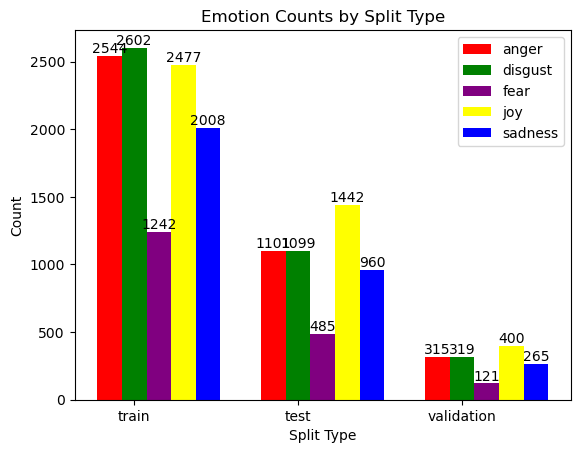

In [7]:
# plot bar graph with emotion counts by spli type
import matplotlib.pyplot as plt
import numpy as np

LABEL2COLOR = {
    'anger': 'red',
    'disgust': 'green',
    'fear':'purple',
    'joy': 'yellow',
    'sadness': 'blue',
}

x = np.arange(len(split_types))
width = 0.15
multiplier = 0

fig, ax = plt.subplots()
for label, counts in emotion_split_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, counts, width, label=label, color=LABEL2COLOR[label])
    ax.bar_label(rects, label_type='edge')
    multiplier += 1

ax.set_xlabel('Split Type')
ax.set_ylabel('Count')
ax.set_title('Emotion Counts by Split Type')
ax.set_xticks(x + width, split_types)
ax.legend()
plt.show()

In [8]:
# get emotion count by label in all split types
emotion_counts = {}
for label in LABEL2ID:
    for split_type in datasets.keys():
        emotion_counts[label] = emotion_counts.get(label,0)+sum(datasets[split_type][label])
        
print(f"EMOTION_COUNTS: {emotion_counts}")

EMOTION_COUNTS: {'anger': 3960, 'disgust': 4020, 'fear': 1848, 'joy': 4319, 'sadness': 3233}


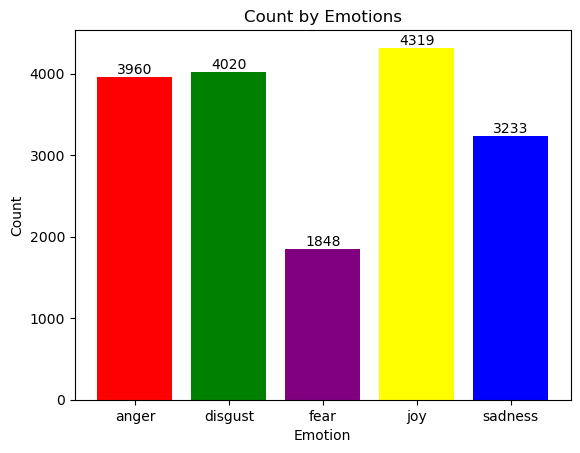

In [9]:
# plot bar graph with total emotion counts
fig, ax = plt.subplots()
bar_container = ax.bar(emotion_counts.keys(), emotion_counts.values(), color=LABEL2COLOR.values())
ax.bar_label(bar_container, label_type='edge')
ax.set_xlabel('Emotion')
ax.set_ylabel('Count')
ax.set_title('Count by Emotions')
plt.show()

## Create Custom Dataset

### Preprocess Data

In [10]:
# this function preprocess our data for training
def preprocess(batch):
    # rename column
    batch['text'] = batch['Tweet']
    # get one-hot encoded labels for each example in batch
    # for example: anger and sadness = vector of [1,0,0,0,1]
    batch['labels'] = [[float(batch[label][i]) for label in LABEL2ID] for i in range(len(batch['text']))]
    return batch

preprocessed_datasets = datasets.map(preprocess, batched=True, remove_columns=datasets['train'].column_names)
preprocessed_datasets

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 886
    })
})

In [11]:
# let's see an example of preprocessed data
preprocessed_datasets['train'][:1]

{'text': ["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry"],
 'labels': [[0.0, 0.0, 0.0, 0.0, 0.0]]}

### Tokenize Data

In [12]:
from transformers import AutoTokenizer

CHECKPOINT = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [13]:
# tokenize out datasets with truncation
tokenized_datasets = preprocessed_datasets.map(lambda batch: tokenizer(batch['text'], truncation=True), batched=True, remove_columns=['text'])
tokenized_datasets

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 886
    })
})

In [14]:
# let's see an example of this
tokenized_datasets['train'][:1]

{'labels': [[0.0, 0.0, 0.0, 0.0, 0.0]],
 'input_ids': [[101,
   1523,
   4737,
   2003,
   1037,
   2091,
   7909,
   2006,
   1037,
   3291,
   2017,
   2089,
   2196,
   2031,
   1005,
   1012,
   11830,
   11527,
   1012,
   1001,
   14354,
   1001,
   4105,
   1001,
   4737,
   102]],
 'attention_mask': [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1]]}

# Train Model

## Set Seed

In [15]:
# set seed for reproducibility
import torch

SEED = 42
torch.manual_seed(SEED)

## Clone Model

In [16]:
# let's clone a model and finetune as a multi-label classification problem
from transformers import AutoModelForSequenceClassification

# source: https://huggingface.co/distilbert-base-uncased
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, problem_type='multi_label_classification', num_labels=len(LABEL2ID), id2label=ID2LABEL, label2id=LABEL2ID)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.we

## Setup Training Metrics

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# this function calculates accuracy per label in a prediction instead of per prediction
def samples_accuracy_score(y_true, y_pred):
    return np.sum(y_true==y_pred) / y_true.size
    
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    # we sigmoid all logits for multilabel metrics
    predictions = torch.nn.functional.sigmoid(torch.Tensor(logits))
    # we set threshold to 0.50 to classify positive >= 0.50 and negative < 0.50
    predictions = (predictions >= 0.50).int().numpy()
    # overall accuracy measures accuracy of each true label list and prediction list
    overall_accuracy = accuracy_score(labels, predictions)
    # sample accuracy measures accuracy of each true label in a true label list and prediction in prediction list 
    samples_accuracy = samples_accuracy_score(labels, predictions)
    # overall f1 measures macro f1 of each true label list and prediction list, ignoring zero division warnings
    overall_f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    # samples f1 measures f1 of each true label in a true label list and prediction in prediction list, ignoring zero division warnings
    samples_f1 = f1_score(labels, predictions, average='samples', zero_division=0)
    return {
        'overall_accuracy': overall_accuracy,
        'samples_accuracy': samples_accuracy,
        'overall_f1': overall_f1,
        'samples_f1': samples_f1,
    }

## Setup Training Configurations

In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    seed=SEED,                          # seed for reproducibility
    output_dir='results',               # output directory to store epoch checkpoints
    num_train_epochs=5,                 # number of training epochs
    optim='adamw_torch',                # default optimizer as AdamW
    per_device_train_batch_size=32,     # 32 train batch size to speed up training
    per_device_eval_batch_size=32,      # 32 eval batch size to speed up evaluation
    evaluation_strategy='epoch',        # set evaluation strategy to each epoch instead of default 500 steps
    save_strategy='epoch',              # set saving of model strategy to each epoch instead of default 500 steps
    load_best_model_at_end=True,        # load the best model with lowest validation loss
    report_to='none',                   # suppress third-party logging
)

## Setup Trainer

In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

## Get Baseline Metrics

In [20]:
# let's see what an unfine-tuned bert can do
trainer.evaluate(tokenized_datasets['test'])

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7146069407463074,
 'eval_overall_accuracy': 0.017796870205584535,
 'eval_samples_accuracy': 0.40018410555385087,
 'eval_overall_f1': 0.30359948042398655,
 'eval_samples_f1': 0.3216608951036689,
 'eval_runtime': 4.4842,
 'eval_samples_per_second': 726.768,
 'eval_steps_per_second': 22.746}

We got **40% Samples Accuracy** and **32% Samples F1**, which is not good. 😕

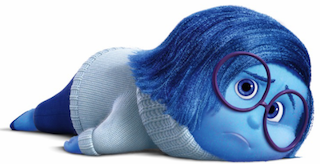

## Train Model

In [21]:
# let's fine-tune bert as a multilabel problem
trainer.train()

Epoch,Training Loss,Validation Loss,Overall Accuracy,Samples Accuracy,Overall F1,Samples F1
1,No log,0.352427,0.528217,0.851919,0.750341,0.723229
2,No log,0.341724,0.518059,0.853725,0.742116,0.705670
3,0.356700,0.363010,0.519187,0.854628,0.758450,0.721138
4,0.356700,0.376084,0.529345,0.858691,0.762991,0.721326
5,0.201500,0.383193,0.524831,0.856433,0.761169,0.728964


TrainOutput(global_step=1070, training_loss=0.2715954370587786, metrics={'train_runtime': 98.401, 'train_samples_per_second': 347.456, 'train_steps_per_second': 10.874, 'total_flos': 417449356203540.0, 'train_loss': 0.2715954370587786, 'epoch': 5.0})

## Get Trained Metrics

In [22]:
# let's see what a finetuned bert can do
trainer.evaluate(tokenized_datasets['test'])

{'eval_loss': 0.3283992409706116,
 'eval_overall_accuracy': 0.5412703283215711,
 'eval_samples_accuracy': 0.8584228290886775,
 'eval_overall_f1': 0.7433491791354239,
 'eval_samples_f1': 0.7111369248527886,
 'eval_runtime': 2.9558,
 'eval_samples_per_second': 1102.577,
 'eval_steps_per_second': 34.508,
 'epoch': 5.0}

**WOAH!** We got **85% Samples Accuracy** and **71% Samples F1** in **5 Epochs**!

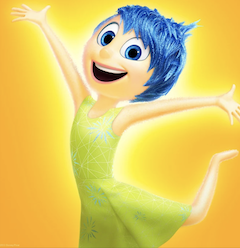

# Let's try out some examples

In [23]:
from transformers import pipeline

twitter_emotion_multilabel_classifier = pipeline(task='text-classification', model=model, tokenizer=tokenizer, device=torch.cuda.current_device(), top_k=None)

## Let's get some quotes from the "Inside Out" movie

In [24]:
anger_tweet = """
We should lock the door and scream that curse word we know.
"""

twitter_emotion_multilabel_classifier(anger_tweet)

[[{'label': 'anger', 'score': 0.8550204038619995},
  {'label': 'disgust', 'score': 0.8197154402732849},
  {'label': 'fear', 'score': 0.525305449962616},
  {'label': 'sadness', 'score': 0.18176916241645813},
  {'label': 'joy', 'score': 0.02061280608177185}]]

In [25]:
disgust_tweet = """
You know what else barely touches the ground? Stray dogs, toenail clippings, road kill, hippies, dung beetles...
"""

twitter_emotion_multilabel_classifier(disgust_tweet)

[[{'label': 'disgust', 'score': 0.6332297921180725},
  {'label': 'anger', 'score': 0.38423871994018555},
  {'label': 'sadness', 'score': 0.2974025011062622},
  {'label': 'fear', 'score': 0.2053983062505722},
  {'label': 'joy', 'score': 0.02278871089220047}]]

In [26]:
fear_tweet = """
I sure am glad you told me earthquakes are a myth, Joy. Otherwise I'd be terrified right now!
"""

twitter_emotion_multilabel_classifier(fear_tweet)

[[{'label': 'fear', 'score': 0.852724552154541},
  {'label': 'joy', 'score': 0.6038024425506592},
  {'label': 'sadness', 'score': 0.0814892053604126},
  {'label': 'disgust', 'score': 0.037913840264081955},
  {'label': 'anger', 'score': 0.03224283084273338}]]

In [27]:
joy_tweet = """
All right, everyone, fresh start. We are gonna have a good day, which will turn into a good week, which will turn into a good year, which turns into a good life!
"""

twitter_emotion_multilabel_classifier(joy_tweet)

[[{'label': 'joy', 'score': 0.9740201234817505},
  {'label': 'sadness', 'score': 0.023017482832074165},
  {'label': 'disgust', 'score': 0.01469943393021822},
  {'label': 'anger', 'score': 0.014311756007373333},
  {'label': 'fear', 'score': 0.008701195009052753}]]

In [28]:
sadness_tweet = """
Crying helps me slow down and obsess over the weight of life's problems.
"""

twitter_emotion_multilabel_classifier(sadness_tweet)

[[{'label': 'sadness', 'score': 0.9652622938156128},
  {'label': 'disgust', 'score': 0.1800491362810135},
  {'label': 'fear', 'score': 0.17279943823814392},
  {'label': 'anger', 'score': 0.05303214117884636},
  {'label': 'joy', 'score': 0.04554196819663048}]]